In [1]:
import tensorflow as tf
import keras
from keras import Model
from keras import layers
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import SLR_model_CL_GRU
import SLR_model_GRU
import importlib
import time
# from sklearn.model_selection import train_test_split

In [3]:
tf.__version__

'2.17.0'

In [ ]:
import preprocess

l_raw, r_raw, p_raw, y_raw, loss_weights_raw = preprocess.load_data(f"1/1")
# l_raws.append(l_raw)
# r_raws.append(r_raw)
# p_raws.append(p_raw)
# y_raws.append(y_raw)
# loss_weights_raws.append(loss_weights_raw)

# if len(l_raws)>=load_size:
# l_train, each = SLR_model.serialize((l_raw,))
# r_train, each = SLR_model.serialize((r_raws,))
p_train, each, sample_weights = SLR_model.serialize((p_raw,), stride=2, loss_weights_list=(loss_weights_raw,))
# x_train = (l_train, r_train, p_train)

y_train = np.repeat((y_raw,), each)
# y_train = SLR_model.encode_onehot2d(y_train)


print(y_train)
x = np.linspace(0,len(sample_weights), len(sample_weights))

plt.plot(x, sample_weights)

# dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
# hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])

In [4]:
load_size = 32

In [42]:
# per video dummy data
# dummy x_raw data

h_elem = np.zeros(shape=(4,5,3))
l_raw = []
duration = np.random.randint(70,111)
for j in range(duration): # frame size
    l_raw.append(h_elem)
h_elem = np.zeros(shape=(4,5,3))
r_raw = []
for j in range(duration): # frame size
    r_raw.append(h_elem)

p_elem = np.zeros(shape=(3,10))
p_raw = []
for j in range(duration): # frame size
    p_raw.append(p_elem)


loss_weights_raw = []

for j in range(duration+1): # frame size
    loss_weights_raw.append(1.0)

y_raw = np.array(2048, dtype=np.uint32)

In [25]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        
        self.times.append((epoch,time.process_time() - self.timetaken))
        print(time.process_time() - self.timetaken)
        self.timetaken = time.process_time()
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()
        
timetaken = timecallback()

In [45]:
importlib.reload(SLR_model_CL_GRU)

<module 'SLR_model_CL_GRU' from 'c:\\Users\\jerry\\Desktop\\hly\\2024-2\\cap\\BN_SLR\\BomNae-SLR-1\\SLR_model_CL_GRU.py'>

In [4]:

model = SLR_model_CL_GRU.reinit_model()

(1, 3000)
(1, 13, 5, 4, 5, 3)
(1, 13, 5, 4, 5, 3)
(1, 13, 5, 10, 3)
Epoch 1/10


c:\SpecialPrograms\Anaconda3\envs\slr\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'slr_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - categorical_accuracy: 0.0000e+00 - loss: 8.006423.9375
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - categorical_accuracy: 0.0000e+00 - loss: 8.0064
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 1.0000 - loss: 7.84795.765625
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - categorical_accuracy: 1.0000 - loss: 7.8479
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 1.0000 - loss: 5.16744.90625
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - categorical_accuracy: 1.0000 - loss: 5.1674
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 1.0000 - loss: 2.64924.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - categorical_accuracy: 1.0000 - loss: 2.6492
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 1.0000 - loss: 2.45764.671875
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - categorical_accuracy: 1.0000 - loss: 2.4576
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 1.0000 - loss: 2.259

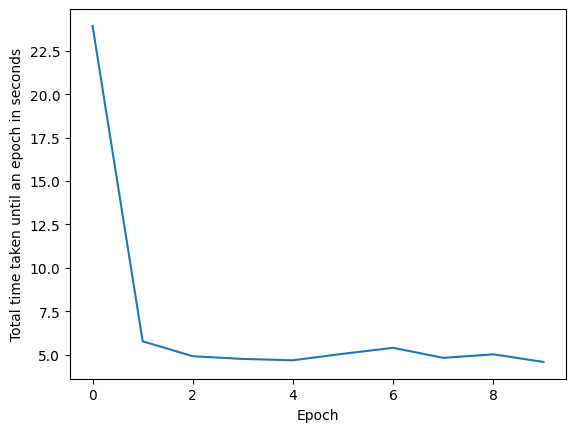

In [5]:
# PER VIDEO TRAINING LOOP

## ----------------------------------------------------
## CLGRU <-> CNNGRU 전환시 serialize 인자값 바꿔줄 것
## --------------------------------------
l_train, window_count = SLR_model_CL_GRU.serialize(l_raw, stride=2, window_size=9, hop_length=6)
r_train, window_count = SLR_model_CL_GRU.serialize(r_raw, stride=2, window_size=9, hop_length=6)
p_train, window_count, sample_weights = SLR_model_CL_GRU.serialize(p_raw, stride=2, window_size=9, hop_length=6, loss_weights=loss_weights_raw, is_pose=True)
x_train = (l_train, r_train, p_train)

y_train = np.repeat(y_raw, window_count)
y_train = SLR_model_CL_GRU.encode_onehot2d(y_raw)
y_train = tf.expand_dims(y_train, axis=0)
# print(y_train.shape)
# print(x_train[0].shape)
# print(x_train[1].shape)
# print(x_train[2].shape)
# print(sample_weights.shape)
dataset = SLR_model_CL_GRU.convert_to_dataset(x_train, y_train, batch_size= 1)#, sample_weights= sample_weights)
hist = model.fit(dataset, epochs=10, callbacks=[timetaken])
                  

In [49]:
pred, stat = model(x_train, training=False, gru_state = stat)

In [54]:
SLR_model_CL_GRU.decode_onehot2d(pred)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2048], dtype=int64)>

In [42]:
stat

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[-1.        , -1.        ,  0.9999969 ,  1.        , -0.9999999 ,
         1.        ,  1.        ,  0.9999986 ,  1.        , -1.        ,
        -1.        , -0.19753836, -1.        , -0.99997187,  0.9999967 ,
         1.        ,  1.        , -1.        ,  1.        , -1.        ,
        -1.        ,  1.        , -1.        , -1.        ,  0.99999994,
        -1.        ,  1.        , -1.        ,  1.        ,  1.        ,
         1.        ,  0.9644135 , -1.        , -1.        , -1.        ,
         0.9996992 , -1.        ,  1.        ,  1.        ,  1.        ,
        -0.99999994, -0.9999989 , -1.        ,  1.        , -1.        ,
         1.        , -1.        , -1.        , -1.        ,  0.9999988 ,
        -1.        ,  1.        ,  1.        , -1.        , -1.        ,
         0.9999998 ,  1.        , -1.        ,  1.        ,  0.99999994,
        -0.9999999 ,  1.        , -1.        , -1.        ,  1.        ,
 

---------------
# CNN GRU

In [39]:
importlib.reload(SLR_model_GRU)


<module 'SLR_model_GRU' from 'c:\\Users\\jerry\\Desktop\\hly\\2024-2\\cap\\BN_SLR\\BomNae-SLR-1\\SLR_model_GRU.py'>

In [40]:
cngru_model = SLR_model_GRU.reinit_model(run_eagerly=False)

In [43]:
# PER VIDEO TRAINING LOOP

## ----------------------------------------------------
## CLGRU <-> CNNGRU 전환시 serialize 인자값 바꿔줄 것
## --------------------------------------
l_train, window_count = SLR_model_GRU.serialize(l_raw, stride=1, window_size=17, hop_length=10)
r_train, window_count = SLR_model_GRU.serialize(r_raw, stride=1, window_size=17, hop_length=10)
p_train, window_count, sample_weights = SLR_model_GRU.serialize(p_raw, stride=2, window_size=9, hop_length=6, loss_weights=loss_weights_raw, is_pose=True)
x_train = (l_train, r_train, p_train)

y_train = np.repeat(y_raw, window_count)
y_train = SLR_model_GRU.encode_onehot2d(y_raw)
y_train = tf.expand_dims(y_train, axis=0)
# print(y_train.shape)
# print("li:",x_train[0].shape)
# print("ri:",x_train[1].shape)
# print(x_train[2].shape)
# print(sample_weights.shape)
dataset = SLR_model_GRU.convert_to_dataset(x_train, y_train, batch_size= 1)#, sample_weights= sample_weights)
hist = cngru_model.fit(dataset, epochs=30)
                  

Epoch 1/30


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - categorical_accuracy: 1.0000 - loss: 0.0000e+00
Epoch 11/30

In [44]:
cngru_model.summary()

Model: "slr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hand_model (HandModel)          │ ?                      │       151,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hand_model_1 (HandModel)        │ ?                      │       151,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pose_model (PoseModel)          │ ?                      │        23,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (1, 256)               │    10,323,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 3000)              │       771,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 1020)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ project (Project)               │ ?                      │     6,547,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ project_1 (Project)             │ ?                      │        58,752 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,083,162 (206.31 MB)

 Trainable params: 18,027,720 (68.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,055,442 (137.54 MB)

In [28]:
for i in range(10):
    pred= cngru_model(x_train, training=False)

In [60]:
SLR_model_GRU.decode_onehot2d(pred)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2048], dtype=int64)>

---------------------------------------

In [17]:
# dummy x_raw data
l_raws = []
duration_list = []
for i in range(load_size):
    h_elem = np.zeros(shape=(4,5,3))
    # p_elem = np.zeros(shape=(3,10))
    # comb_elem = [h_elem, h_elem, p_elem]
    x_elem = []
    duration = (np.random.randint(70,91))
    duration_list.append(duration)
    for j in range(duration): # frame size
        x_elem.append(h_elem)
        # x_elem.append(comb_elem)
    l_raws.append(x_elem)
r_raws = []
for i in range(load_size):
    h_elem = np.zeros(shape=(4,5,3))
    # p_elem = np.zeros(shape=(3,10))
    # comb_elem = [h_elem, h_elem, p_elem]
    x_elem = []
    duration = duration_list[i]
    for j in range(duration): # frame size
        x_elem.append(h_elem)
        # x_elem.append(comb_elem)
    r_raws.append(x_elem)
p_raws = []
for i in range(load_size):
    # h_elem = np.zeros(shape=(4,5,3))
    p_elem = np.zeros(shape=(3,10))
    # comb_elem = [h_elem, h_elem, p_elem]
    x_elem = []
    duration = duration_list[i]
    for j in range(duration): # frame size
        # x_elem.append(h_elem)
        x_elem.append(p_elem)
        # x_elem.append(comb_elem)
    p_raws.append(x_elem)
    
loss_weights_raws = []
for i in range(load_size):
    x_elem = []
    duration = duration_list[i]
    for j in range(duration): # frame size
        x_elem.append(2.0)
    loss_weights_raws.append(x_elem)

# dummy y_raw data
# y_raw = np.random.randint(0,1024,load_size)
y_raws = np.full((load_size,), 2048,  dtype=np.int32)

NameError: name 'load_size' is not defined

In [14]:
importlib.reload(SLR_model)

<module 'SLR_model' from 'c:\\Users\\jerry\\Desktop\\hly\\2024-2\\cap\\BN_SLR\\BomNae-SLR-1\\SLR_model.py'>

In [6]:
oh = SLR_model.encode_onehot2d([0,0,3,7,6,2])

In [8]:
oh

<tf.Tensor: shape=(6, 3000), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>

In [7]:
SLR_model.decode_onehot2d(oh)

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 3, 7, 6, 2], dtype=int64)>

In [16]:
y_raws

NameError: name 'y_raws' is not defined

In [24]:
batch_size = 8
# model = SLR_model.reinit_model(True)
model = SLR_model.get_model()

l_train, each = SLR_model.serialize(l_raws)
r_train, each = SLR_model.serialize(r_raws)
print(len(p_raws), len(loss_weights_raws))
p_train, each, sample_weights = SLR_model.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
y_train_truth = np.repeat(y_raws, each)
y_train_truth1 = SLR_model.num_arr2bin(y_train_truth, 12)
# check

print("lw_S:", len(sample_weights))
print("yt_S:", y_train_truth1.shape)

# y_train = tf.concat((y_train_truth1, loss_weights), axis = 1)

# y_train = tf.zeros(shape=(113,6,12))
x_train = (l_train, r_train, p_train)

print("xt[0]_S:", x_train[0].shape)
# print("y_train shape: (", y_train[0].shape,', ', len(y_train[1]), ')')
dataset = SLR_model.convert_to_dataset(x_train, y_train_truth1, batch_size, sample_weights)
for i in dataset:
    print(i[1].shape)
    break
hist = model.fit(dataset, epochs=1)


32 32
lw_S: 99
yt_S: (99, 12)
xt[0]_S: (99, 63, 4, 5, 3)
(8, 12)
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.8074 - loss: 1.3836


In [187]:
aa = tf.zeros(shape = (3,12), dtype= tf.float32)
ab = tf.ones(shape = (3,1),dtype= tf.float32)

In [189]:
a = tf.concat((aa, ab), axis=1)

In [191]:
a.numpy()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)

In [196]:
a[:,:12].numpy()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [198]:
a[:,12]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>

---
**keras layer test**

In [102]:
inputs = layers.Input(shape=(32, 3, 10), batch_size=18)
# frame channel feat
d2 = layers.Dense(3, activation='relu')
outputs = layers.TimeDistributed(d2)(inputs)
outputs.shape

TensorShape([18, 32, 3, 3])

In [103]:
outputs = layers.Permute((2, 1, 3))(outputs)
outputs = tf.expand_dims(outputs, axis=4)
outputs.shape

TensorShape([18, 3, 32, 3, 1])

In [104]:
xyz = tf.split(outputs, 3, axis = 1)

In [105]:
xyz

[<KerasTensor: shape=(18, 1, 32, 3, 1) dtype=float32 (created by layer 'tf.split_3')>,
 <KerasTensor: shape=(18, 1, 32, 3, 1) dtype=float32 (created by layer 'tf.split_3')>,
 <KerasTensor: shape=(18, 1, 32, 3, 1) dtype=float32 (created by layer 'tf.split_3')>]

In [147]:
c2 = layers.Conv2D(1, (17,3))
x = c2(xyz[0])
y = c2(xyz[1])
z = c2(xyz[2])
x.shape

TensorShape([18, 1, 16, 1, 1])

In [148]:
x = tf.squeeze(x)
y = tf.squeeze(y)
z = tf.squeeze(z)
x.shape

TensorShape([18, 16])

In [151]:
o = tf.stack([x,y,z], axis=2)
# o = tf.concat([x,y,z], axis = 0)
o.shape

TensorShape([18, 16, 3])

In [43]:
tf.squeeze(outputs)

<KerasTensor: shape=(32, 3, 16, 2) dtype=float32 (created by layer 'tf.compat.v1.squeeze_3')>

- hand model layer test -

In [145]:
inputs = layers.Input(shape=(63, 4, 5, 3), batch_size=32)
# frame, w, h, channel
c21d = Conv2Plus1D(kernel_size=(33,3,3), strides=(2, 1, 1))
outputs = c21d(inputs)
outputs.shape

TensorShape([32, 16, 2, 3, 1])

In [59]:
o2 = layers.Flatten()(outputs)
o2.shape

TensorShape([32, 96])

In [146]:
o2 = outputs
o2 = layers.Reshape((16, o2.shape[2] * o2.shape[3]* o2.shape[4]))(o2)
o2.shape

TensorShape([32, 16, 6])

- combined layer test

In [161]:
l_res = layers.Input(shape=(16, 6), batch_size=32)
r_res = layers.Input(shape=(16, 6), batch_size=32)
p_res = layers.Input(shape=(16, 3), batch_size=32)
fl = layers.Flatten()
lflt =fl(l_res)
rflt = fl(r_res)
pflt = fl(p_res)
ult_flat = tf.concat([lflt, rflt, pflt], axis = 1)
ult_flat.shape

TensorShape([32, 240])

**layer test**

---

**other experiments**

In [138]:
asdf = tf.constant(([0.1, 0.2, 0.3, 0.4],[1, 2, 3, 4], [11,22,33,44]))
# asdf = tf.expand_dims(asdf, axis=0)

asdf.numpy()

array([[ 0.1,  0.2,  0.3,  0.4],
       [ 1. ,  2. ,  3. ,  4. ],
       [11. , 22. , 33. , 44. ]], dtype=float32)

In [140]:
ashpe = asdf.shape
ashpe

TensorShape([3, 4])

In [144]:
asdf = tf.reshape(asdf, (1,12))
ashpe

TensorShape([3, 4])

In [124]:
ababs = tf.split(asdf, 3)
ababs

[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.1, 0.2, 0.3, 0.4]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 2., 3., 4.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11., 22., 33., 44.]], dtype=float32)>]

In [125]:
abab = tf.stack([ababs[0],ababs[1],ababs[2]], axis=2)
abab.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(1, 4, 3), dtype=float32, numpy=
array([[[ 0.1,  1. , 11. ],
        [ 0.2,  2. , 22. ],
        [ 0.3,  3. , 33. ],
        [ 0.4,  4. , 44. ]]], dtype=float32)>>

In [99]:
tf.transpose(asdf)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.1,  1. , 10. ],
       [ 0.2,  2. , 20. ],
       [ 0.3,  3. , 30. ]], dtype=float32)>

In [92]:
for i,val in enumerate(asdf):
    print(val.numpy())
    print(i)

[1. 1.]
0
[1. 1.]
1
[1. 1.]
2
[1. 1.]
3


---
**Multi input test**

In [3]:
class MultiInputModel(tf.keras.Model):
    def __init__(self):
        super(MultiInputModel, self).__init__()
        
        # Define layers for input 1
        self.dense1 = tf.keras.layers.Dense(2, activation='relu')
        
        # Define layers for input 2
        self.dense3 = tf.keras.layers.Dense(3, activation='relu')

        
        # Common layers for both inputs
        self.concat = tf.keras.layers.Concatenate()
        self.dense_final = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        # Unpack inputs
        input1, input2 = inputs
        
        # Process input 1
        x1 = self.dense1(input1)
        
        # Process input 2
        x2 = self.dense3(input2)
        
        # Concatenate the processed inputs
        x = self.concat([x1, x2])
        
        # Final dense layer
        output = self.dense_final(x)
        
        return output

In [7]:
model = MultiInputModel()

# Dummy inputs for demonstration (e.g., two inputs with 8 features each)
input1 = np.ones((32, 8))  # Batch size 32, 8 features
input2 = np.zeros((32, 4))  # Batch size 32, 8 features
# input2 = tf.random.normal((32, 4))  # Batch size 32, 8 features

# Forward pass
output = model([input1, input2])

# Print the model summary
model.summary()

# Print the output shape
print(f"Output shape: {output.shape}")

Model: "multi_input_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             multiple                  18        
                                                                 
 dense_7 (Dense)             multiple                  15        


                                                                 
 concatenate_2 (Concatenate)  multiple                 0         
                                                                 
 dense_8 (Dense)             multiple                  6         
                                                                 
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________
Output shape: (32, 1)


In [8]:
model.predict([input1, input2])

1/1 [==============================] - 0s 92ms/step


array([[0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424],
       [0.8391424]], dtype=float32)